In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import csv
from datetime import timedelta

In [6]:
class log_returns_class():
    def __init__(self, currencyOfInterest, Rate, file_name):
        df = pd.read_csv(file_name)
        dataOI = df[df['Currency']==currencyOfInterest]
        dates = pd.to_datetime(dataOI['Date'])
        spotRates = dataOI[Rate]
        self.log_returns = np.log(spotRates/spotRates.shift(1)).dropna()
        self.dates_log = dates.dropna()
        self.spotRates = spotRates
        self.currencyOfInterest = currencyOfInterest
    
    def autocorl_length(self):
        acf,confidence_interval=sm.tsa.acf(self.spotRates,nlags=len(self.spotRates), alpha=0.05,fft=False)
        lower_bound = confidence_interval[1:, 0] - acf[1:]
        for i in range(len(acf)):
            if (-lower_bound[i])>acf[i]:
                self.AUTO_length = i
                break

In [7]:
def stats_SD(currencyOfInterest, Rate, file_name, SD):
    LOG_RET = log_returns_class(currencyOfInterest, Rate, file_name)
    log_returns = LOG_RET.log_returns
    dates_log = LOG_RET.dates_log
    LOG_RET.autocorl_length()
    sliding_size = LOG_RET.AUTO_length
    Anom_log = []
    DATE = dates_log.iloc[0]
    for i in range(len(log_returns)-sliding_size):
        window = []
        for j in range(sliding_size):
            window.append(log_returns.iloc[i+j])
        MEAN = np.mean(window)
        STANDARD = np.std(window)
        if log_returns.iloc[i+sliding_size] > MEAN+(SD*STANDARD):
            Anom_log.append(dates_log.iloc[i+sliding_size])
        if log_returns.iloc[i+sliding_size] < MEAN-(SD*STANDARD):
            Anom_log.append(dates_log.iloc[i+sliding_size])
        if log_returns.iloc[i+sliding_size] == 0:
            Anom_log.append(dates_log.iloc[i+sliding_size])
    #Anom_log = pd. DataFrame(Anom_log)
    return(Anom_log)

In [8]:
currencyOfInterest = 'GBP'
Rates = np.array(["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate", "10Y Rate"])
file_name = "C:/Users/phbcat/Downloads/1128_1419_fx_tenor_curves_lboro_data_with_anomalies.txt"
file_name = "C:/Users/phbcat/OneDrive - Loughborough University/Group Project/Data/1331_1453_fx_tenor_curves_lboro_data_with_anomalies.txt"


def ROC_SD(currencyOfInterest, Rates, file_name):     
    df = pd.read_csv(file_name)

    LOG_RET = log_returns_class(currencyOfInterest, "Spot Rate", file_name)
    LOG_RET.autocorl_length()
    sliding_size = LOG_RET.AUTO_length
    
    dataOI = df[df['Currency']==currencyOfInterest]
    dates = pd.to_datetime(dataOI['Date'])
    True_Anomilies = dataOI["Anomaly Flag"]
    True_Anomilies = pd.concat([dates, True_Anomilies], axis = 1)
    True_Anomilies = True_Anomilies[True_Anomilies['Date']>True_Anomilies.iloc[sliding_size][0]]
    True_Anomilies = True_Anomilies[True_Anomilies['Anomaly Flag']==1]
    True_Anomilies = True_Anomilies['Date']
    
    TRUE_POSITVE_ARRAY = []
    FALSE_POSITIVE_ARRAY = []
    TRUE_POSITVE_ARRAY.append(1)
    FALSE_POSITIVE_ARRAY.append(1)

    
    for k in range(0, 25,2):
        SD = k/2
        anoms = stats_SD(currencyOfInterest, Rates[0], file_name, SD)
        for i in range(len(Rates)-1):
            anoms_1 = stats_SD(currencyOfInterest, Rates[i+1], file_name, SD)
            anoms = anoms + anoms_1

        anoms = pd. DataFrame(anoms)    
        anoms = pd.to_datetime(anoms[0])
        anoms = anoms.sort_values( ascending=True)
        found_anoms = anoms.drop_duplicates(keep='first', inplace=False)
        True_pos = 0
        for i in range(len(found_anoms)):
            for j in range(len(True_Anomilies)):
                if found_anoms.iloc[i]==True_Anomilies.iloc[j]:
                    True_pos+=1
                    break
        False_pos = len(found_anoms) - True_pos
        TRUE_POSITVE_ARRAY.append(True_pos/(len(True_Anomilies)))
        FALSE_POSITIVE_ARRAY.append(False_pos/(len(dates)-len(True_Anomilies)))
    TRUE_POSITVE_ARRAY.append(0)
    FALSE_POSITIVE_ARRAY.append(0)
    return(TRUE_POSITVE_ARRAY, FALSE_POSITIVE_ARRAY)


In [9]:
#TRUE_POSITVE_ARRAY, FALSE_POSITIVE_ARRAY = ROC_SD(currencyOfInterest, Rates, file_name)
#plt.plot(FALSE_POSITIVE_ARRAY, TRUE_POSITVE_ARRAY)
#plt.xlim(0,1)
#plt.ylim(0,1)

In [10]:
def stats_IQR(currencyOfInterest, Rate, file_name, NUM_IQR):
    LOG_RET = log_returns_class(currencyOfInterest, Rate, file_name)
    log_returns = LOG_RET.log_returns
    dates_log = LOG_RET.dates_log
    LOG_RET.autocorl_length()
    sliding_size = LOG_RET.AUTO_length
    Anom_log = []
    for i in range(len(log_returns)-sliding_size):
        window = []
        for j in range(sliding_size):
            window.append(log_returns.iloc[i+j])
        q1, q3 = np.percentile(window,[25, 75])
        IQR = q3-q1
        if log_returns.iloc[i+sliding_size] > q3+IQR*NUM_IQR:
            Anom_log.append(dates_log.iloc[i+sliding_size])
        if log_returns.iloc[i+sliding_size] < q1-IQR*NUM_IQR:
            Anom_log.append(dates_log.iloc[i+sliding_size])
        if log_returns.iloc[i+sliding_size] == 0:
            Anom_log.append(dates_log.iloc[i+sliding_size])
    return(Anom_log)

In [11]:
currencyOfInterest = 'GBP'
Rates = np.array([["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate", "10Y Rate"],
                  ["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate", "10Y Rate"],
                  ["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate", "10Y Rate"],
                  ["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate", "10Y Rate"],
                  ["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate", "10Y Rate"],
                  ["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate", "10Y Rate"],
                  ["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate", "10Y Rate"],
                  ["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate"]])
#Rates= np.array([["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate", "10Y Rate"],
#                 ["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate", "10Y Rate"],
#                 ["Spot Rate", "1W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "5Y Rate"]])

file_name = "C:/Users/phbcat/Downloads/1128_1419_fx_tenor_curves_lboro_data_with_anomalies.txt"
file_name = "C:/Users/phbcat/OneDrive - Loughborough University/Group Project/Data/1331_1453_fx_tenor_curves_lboro_data_with_anomalies.txt"

def ROC_IQR(currencyOfInterest, Rates, file_name):
    df = pd.read_csv(file_name)
    
    LOG_RET = log_returns_class(currencyOfInterest, "Spot Rate", file_name)
    LOG_RET.autocorl_length()
    sliding_size = LOG_RET.AUTO_length
    
    dataOI = df[df['Currency']==currencyOfInterest]
    dates = pd.to_datetime(dataOI['Date'])
    True_Anomilies = dataOI["Anomaly Flag"]
    True_Anomilies = pd.concat([dates, True_Anomilies], axis = 1)
    True_Anomilies = True_Anomilies[True_Anomilies['Date']>True_Anomilies.iloc[sliding_size][0]]
    True_Anomilies = True_Anomilies[True_Anomilies['Anomaly Flag']==1]
    True_Anomilies = True_Anomilies['Date']
    

    
    TRUE_POSITVE_ARRAY = []
    FALSE_POSITIVE_ARRAY = []
    TRUE_POSITVE_ARRAY.append(1)
    FALSE_POSITIVE_ARRAY.append(1)
    for k in range(0, 25,2):
        IQR = k/2
        anoms = stats_IQR(currencyOfInterest, Rates[0], file_name, IQR)
        for i in range(len(Rates)-1):
            anoms_1 = stats_IQR(currencyOfInterest, Rates[i+1], file_name, IQR)
            anoms = anoms + anoms_1

        anoms = pd. DataFrame(anoms)    
        anoms = pd.to_datetime(anoms[0])
        anoms = anoms.sort_values( ascending=True)
        found_anoms = anoms.drop_duplicates(keep='first', inplace=False)

        True_pos = 0
        for i in range(len(found_anoms)):
            for j in range(len(True_Anomilies)):
                if found_anoms.iloc[i]==True_Anomilies.iloc[j]:
                    True_pos+=1
                    break
        False_pos = len(found_anoms) - True_pos
        TRUE_POSITVE_ARRAY.append(True_pos/(len(True_Anomilies)))
        FALSE_POSITIVE_ARRAY.append(False_pos/(len(dates)-len(True_Anomilies)))
    TRUE_POSITVE_ARRAY.append(0)
    FALSE_POSITIVE_ARRAY.append(0)
    return(TRUE_POSITVE_ARRAY, FALSE_POSITIVE_ARRAY)

C:\Users\phbcat\AppData\Local\Temp\ipykernel_18656\3915808925.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Rates = np.array([["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate", "10Y Rate"],


GBP  AUC:  0.984
JPY  AUC:  0.982
NOK  AUC:  0.993
EUR  AUC:  0.986
AUD  AUC:  0.98
NZD  AUC:  0.998
DKK  AUC:  0.997


Text(0.5, 1.0, 'ROC graphs using IQR')

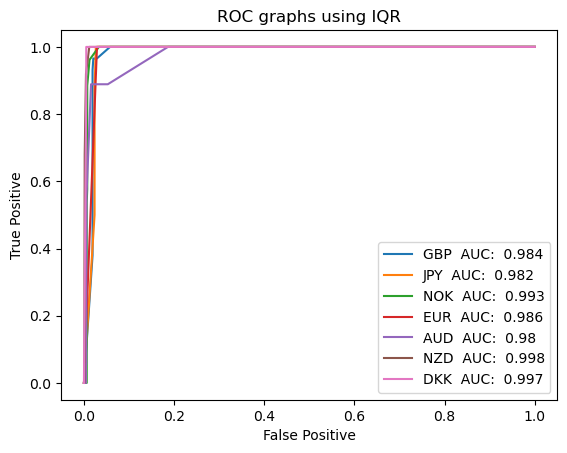

In [12]:
Currencies = np.array(["GBP","JPY","NOK", "EUR","AUD", "NZD", "DKK"])
#Currencies = np.array(["GBP","NOK", "INR"])

Y_IQR = np.zeros((13, len(Currencies)))
X_IQR = []


for i in range(len(Currencies)):
    TRUE_POSITVE_ARRAY, FALSE_POSITIVE_ARRAY = ROC_IQR(Currencies[i], Rates[i], file_name)
    legend = str(Currencies[i])+"  AUC:  "+str(round(-np.trapz(TRUE_POSITVE_ARRAY,FALSE_POSITIVE_ARRAY),3))
    plt.plot(FALSE_POSITIVE_ARRAY, TRUE_POSITVE_ARRAY, label=legend)
    print(legend)

    for j in range(len(TRUE_POSITVE_ARRAY)-2):
        if FALSE_POSITIVE_ARRAY[j]!=0:
            Y_IQR[j][i] = TRUE_POSITVE_ARRAY[j+1]#/FALSE_POSITIVE_ARRAY[j+1]
for k in range(0, 25,2):
    SD = k/2
    X_IQR.append(SD)
    
    

#plt.xlim(0,1)
#plt.ylim(0,1)
plt.legend()
plt.ylabel("True Positive")
plt.xlabel("False Positive")
plt.title("ROC graphs using IQR")

GBP  AUC:  0.98
JPY  AUC:  0.979
NOK  AUC:  0.993
EUR  AUC:  0.971
AUD  AUC:  0.98
NZD  AUC:  0.996
DKK  AUC:  0.972


Text(0.5, 1.0, 'ROC graphs using SD')

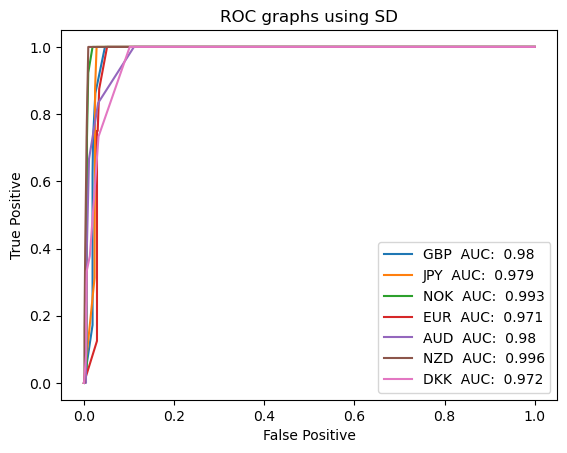

In [13]:
#Currencies = np.array(["GBP","JPY","NOK", "EUR","AUD", "NZD", "DKK", "HKD"])
#Currencies = np.array(["HKD"])
Y_SD = np.zeros((13, len(Currencies)))
X_SD = []

for i in range(len(Currencies)):
    TRUE_POSITVE_ARRAY, FALSE_POSITIVE_ARRAY = ROC_SD(Currencies[i], Rates[i], file_name)
    legend = str(Currencies[i])+"  AUC:  "+str(round(-np.trapz(TRUE_POSITVE_ARRAY,FALSE_POSITIVE_ARRAY),3))
    plt.plot(FALSE_POSITIVE_ARRAY, TRUE_POSITVE_ARRAY, label=legend)
    print(legend)
    for j in range(len(TRUE_POSITVE_ARRAY)-2):
        if FALSE_POSITIVE_ARRAY[j]!=0:
            Y_SD[j][i] = TRUE_POSITVE_ARRAY[j+1]#/FALSE_POSITIVE_ARRAY[j+1]
for k in range(0, 25,2):
    SD = k/2
    X_SD.append(SD)

#plt.xlim(0,1)
#plt.ylim(0,1)
plt.legend()
plt.ylabel("True Positive")
plt.xlabel("False Positive")
plt.title("ROC graphs using SD")

Text(0, 0.5, 'True positives')

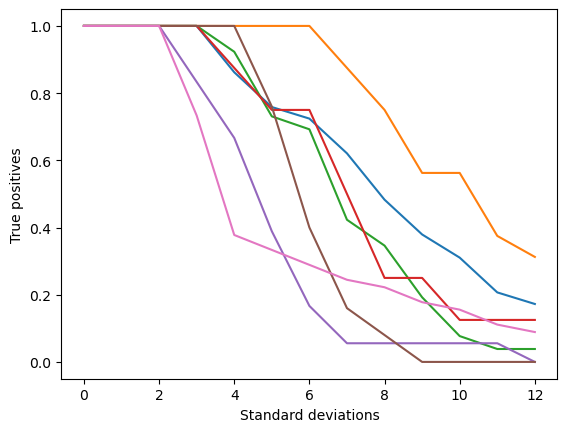

In [14]:
plt.plot(X_SD,Y_SD,label=Currencies)
plt.xlabel("Standard deviations")
plt.ylabel("True positives")
plt.title("Investigation into the ")
#plt.ylabel("True / False positives")
#plt.legend()

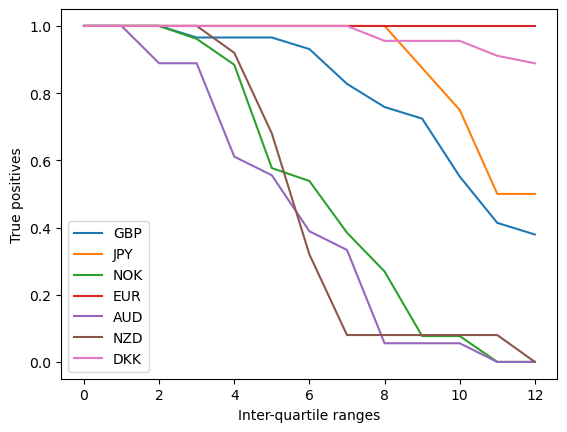

In [15]:
plt.plot(X_IQR,Y_IQR,label=Currencies)
plt.xlabel("Inter-quartile ranges")
plt.ylabel("True positives")
#plt.ylabel("True / False positives")
plt.legend()

In [16]:
len(X_IQR)
len(Y_IQR)

13